In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import GroupKFold
from sklearn.metrics import f1_score 
    
import gc
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
nvidia_gpu = tf.config.experimental.list_physical_devices('GPU')

if nvidia_gpu:
    from tensorflow.keras import Model
    from tensorflow.keras.layers import *
    from tensorflow.keras.callbacks import Callback, LearningRateScheduler, EarlyStopping
    from tensorflow.keras.losses import categorical_crossentropy
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras import backend as K
    from tensorflow.keras import losses, models, optimizers

else:
    import plaidml.keras
    plaidml.keras.install_backend()
    import os
    os.environ['KERAS_BACKEND'] = 'plaidml.keras.backend'

    import keras
    from keras import Model
    from keras.layers import *
    from keras.callbacks import Callback, LearningRateScheduler, EarlyStopping
    from keras.losses import categorical_crossentropy
    from keras.optimizers import Adam
    from keras import backend as K
    from keras import losses, models, optimizers

In [32]:
# configurations and main hyperparammeters
EPOCHS = 110
NNBATCHSIZE = 16
GROUP_BATCH_SIZE = 4000
SEED = 321
LR = 0.0015
SPLITS = 4


def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
# read data
def read_data():
    train = pd.read_csv('./data/train_clean.csv',
                        dtype={
                            'time': np.float32,
                            'signal': np.float32,
                            'open_channels': np.int32
                        })
    test = pd.read_csv('./data/test_clean.csv',
                       dtype={
                           'time': np.float32,
                           'signal': np.float32
                       })
    sub = pd.read_csv('./data/sample_submission.csv',
                      dtype={'time': np.float32})

    Y_train_proba = np.load("./data/Y_train_proba.npy")
    Y_test_proba = np.load("./data/Y_test_proba.npy")

    for i in range(11):
        train[f"proba_{i}"] = Y_train_proba[:, i]
        test[f"proba_{i}"] = Y_test_proba[:, i]

    return train, test, sub


# create batches of 4000 observations
def batching(df, batch_size):
    df['group'] = df.groupby(df.index // batch_size,
                             sort=False)['signal'].agg(['ngroup']).values
    df['group'] = df['group'].astype(np.uint16)
    return df


# normalize the data (standard scaler). We can also try other scalers for a better score!
def normalize(train, test):
    train_input_mean = train.signal.mean()
    train_input_sigma = train.signal.std()
    train['signal'] = (train.signal - train_input_mean) / train_input_sigma
    test['signal'] = (test.signal - train_input_mean) / train_input_sigma
    return train, test


# get lead and lags features
def lag_with_pct_change(df, windows):
    for window in windows:
        df['signal_shift_pos_' +
           str(window)] = df.groupby('group')['signal'].shift(window).fillna(0)
        df['signal_shift_neg_' +
           str(window)] = df.groupby('group')['signal'].shift(-1 *
                                                              window).fillna(0)
    return df


# main module to run feature engineering. Here you may want to try and add other features and check if your score imporves :).
def run_feat_engineering(df, batch_size):
    # create batches
    df = batching(df, batch_size=batch_size)
    # create leads and lags (1, 2, 3 making them 6 features)
    df = lag_with_pct_change(df, [1, 2, 3])
    # create signal ** 2 (this is the new feature)
    df['signal_2'] = df['signal']**2
    return df


# fillna with the mean and select features for training
def feature_selection(train, test):
    features = [
        col for col in train.columns
        if col not in ['index', 'group', 'open_channels', 'time']
    ]
    train = train.replace([np.inf, -np.inf], np.nan)
    test = test.replace([np.inf, -np.inf], np.nan)
    for feature in features:
        feature_mean = pd.concat([train[feature], test[feature]],
                                 axis=0).mean()
        train[feature] = train[feature].fillna(feature_mean)
        test[feature] = test[feature].fillna(feature_mean)
    return train, test, features



# function that decrease the learning as epochs increase
def lr_schedule(epoch):
    if epoch < 30:
        lr = LR
    elif epoch < 40:
        lr = LR / 3
    elif epoch < 50:
        lr = LR / 5
    elif epoch < 60:
        lr = LR / 7
    elif epoch < 70:
        lr = LR / 9
    elif epoch < 80:
        lr = LR / 11
    elif epoch < 90:
        lr = LR / 13
    else:
        lr = LR / 100
    return lr


# class to get macro f1 score. This is not entirely necessary but
# it's fun to check f1 score of each epoch (be carefull,
# if you use this function early stopping callback will not work)
class MacroF1(Callback):
    def __init__(self, model, inputs, targets):
        self.model = model
        self.inputs = inputs
        self.targets = np.argmax(targets, axis=2).reshape(-1)

    def on_epoch_end(self, epoch, logs):
        pred = np.argmax(self.model.predict(self.inputs), axis=2).reshape(-1)
        score = f1_score(self.targets, pred, average='macro')
        print(f'F1 Macro Score: {score:.5f}')


# main function to perfrom groupkfold cross validation
# (we have 1000 vectores of 4000 rows and 8 features (columns)).
# Going to make 5 groups with this subgroups.
def run_cv_model_by_batch(train, test, splits, batch_col, feats,
                          sample_submission, nn_epochs, nn_batch_size):

    seed_everything(SEED)
    K.clear_session()
    config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                      inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),
                                config=config)
    tf.compat.v1.keras.backend.set_session(sess)
    oof_ = np.zeros((len(train), 11))
    # build out of folds matrix with 11 columns,
    #they represent our target variables classes (from 0 to 10)
    preds_ = np.zeros((len(test), 11))
    target = ['open_channels']
    group = train['group']
    kf = GroupKFold(n_splits=5)
    splits = [x for x in kf.split(train, train[target], group)]

    new_splits = []
    for sp in splits:
        new_split = []
        new_split.append(np.unique(group[sp[0]]))
        new_split.append(np.unique(group[sp[1]]))
        new_split.append(sp[1])
        new_splits.append(new_split)

    # pivot target columns to transform the net to a multiclass classification
    # estructure (you can also leave it in 1 vector with
    # sparsecategoricalcrossentropy loss function)
    tr = pd.concat([pd.get_dummies(train.open_channels), train[['group']]],
                   axis=1)

    tr.columns = ['target_' + str(i) for i in range(11)] + ['group']
    target_cols = ['target_' + str(i) for i in range(11)]
    train_tr = np.array(
        list(tr.groupby('group').apply(
            lambda x: x[target_cols].values))).astype(np.float32)
    train = np.array(
        list(train.groupby('group').apply(lambda x: x[feats].values)))
    test = np.array(
        list(test.groupby('group').apply(lambda x: x[feats].values)))

    for n_fold, (tr_idx, val_idx, val_orig_idx) in enumerate(new_splits[0:],
                                                             start=0):
        train_x, train_y = train[tr_idx], train_tr[tr_idx]
        valid_x, valid_y = train[val_idx], train_tr[val_idx]
        print(f'Our training dataset shape is {train_x.shape}')
        print(f'Our validation dataset shape is {valid_x.shape}')

        gc.collect()
        shape_ = (None, train_x.shape[2])
        # input is going to be the number of feature we are using
        # (dimension 2 of 0, 1, 2)
        model = wavenet(shape_)
        # using our lr_schedule function
        cb_lr_schedule = LearningRateScheduler(lr_schedule)
        #-------------------
        model.fit(
            train_x,
            train_y,
            epochs=nn_epochs,
            callbacks=[
                cb_lr_schedule,
                EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1)
            ],  # adding custom evaluation metric for each epoch
            batch_size=nn_batch_size,
            verbose=2,
            validation_data=(valid_x, valid_y))
        #-------------------
        preds_f = model.predict(valid_x)
        f1_score_ = f1_score(
            np.argmax(valid_y, axis=2).reshape(-1),
            np.argmax(preds_f, axis=2).reshape(-1),
            average='macro'
        )  # need to get the class with the biggest probability
        print(
            f'Training fold {n_fold + 1} completed. macro f1 score : {f1_score_ :1.5f}'
        )
        #-------------------
        preds_f = preds_f.reshape(-1, preds_f.shape[-1])
        oof_[val_orig_idx, :] += preds_f
        
        te_preds = model.predict(test)
        te_preds = te_preds.reshape(-1, te_preds.shape[-1])
        preds_ += te_preds / SPLITS
        
    # calculate the oof macro f1_score
    f1_score_ = f1_score(np.argmax(train_tr, axis=2).reshape(-1),
                         np.argmax(oof_, axis=1),
                         average='macro')
    # axis 2 for the 3 Dimension array and axis 1 for the 2 Domension Array
    # (extracting the best class)
    print(f'Training completed. oof macro f1 score : {f1_score_:1.5f}')
    sample_submission['open_channels'] = np.argmax(preds_, axis=1).astype(int)
    sample_submission.to_csv('submission_wavenet.csv',
                             index=False,
                             float_format='%.4f')

In [3]:
def Classifier(shape_):
    def cbr(x, out_layer, kernel, stride, dilation):
        # Case-based reasoning
        x = Conv1D(out_layer,
                   kernel_size=kernel,
                   dilation_rate=dilation,
                   strides=stride,
                   padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        return x

    def wave_block(x, filters, kernel_size, n):
        dilation_rates = [2**i for i in range(n)]
        x = Conv1D(filters=filters, kernel_size=1, padding='same')(x)
        res_x = x

        for dilation_rate in dilation_rates:

            tanh_out = Conv1D(filters=filters,
                              kernel_size=kernel_size,
                              padding='same',
                              activation='tanh',
                              dilation_rate=dilation_rate)(x)

            sigm_out = Conv1D(filters=filters,
                              kernel_size=kernel_size,
                              padding='same',
                              activation='sigmoid',
                              dilation_rate=dilation_rate)(x)
            x = Multiply()([tanh_out, sigm_out])
            x = Conv1D(filters=filters, kernel_size=1, padding='same')(x)
            res_x = Add()([res_x, x])
        return res_x

    inp = Input(shape=(shape_))
    x = cbr(inp, 64, 7, 1, 1)
    x = BatchNormalization()(x)
    x = wave_block(x, 16, 3, 12)
    x = BatchNormalization()(x)
    x = wave_block(x, 32, 3, 8)
    x = BatchNormalization()(x)
    x = wave_block(x, 64, 3, 4)
    x = BatchNormalization()(inp)
    x = wave_block(x, 128, 3, 1)
    x = cbr(x, 32, 7, 1, 1)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    out = Dense(11, activation='softmax', name='out')(x)

    model = models.Model(inputs=inp, outputs=out)

    opt = Adam(lr=LR)
    model.compile(loss=categorical_crossentropy,
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

![image](./WaveNet.png)

In [33]:
def wavenet(shape_):
    """
    WaveNet: A Generative Model for Raw Audio (Google)
    """
    # hyper-parameters
    n_filters = 128
    filter_width = 5
    dilation_rates = [2**i for i in range(12)]

    # define an input history series and pass it through a stack of dilated causal convolution blocks
    input_x = Input(shape=shape_)
    x = BatchNormalization()(input_x)
    skips = []
    
    for dilation_rate in dilation_rates:

        # preprocessing - equivalent to time-distributed dense
        x = Conv1D(16, 1, padding='same', activation='relu')(x) 

        # filter
        x_f = Conv1D(filters=n_filters,
                     kernel_size=filter_width, 
                     padding='causal',
                     dilation_rate=dilation_rate)(x)

        # gate
        x_g = Conv1D(filters=n_filters,
                     kernel_size=filter_width, 
                     padding='causal',
                     dilation_rate=dilation_rate)(x)

        # combine filter and gating branches
        z = Multiply()([Activation('tanh')(x_f),
                        Activation('sigmoid')(x_g)])

        # postprocessing - equivalent to time-distributed dense
        z = Conv1D(16, 1, padding='same', activation='relu')(z)

        # residual connection
        x = Add()([x, z])    

        # collect skip connections
        skips.append(z)

    # add all skip connection outputs 
    out = Activation('relu')(Add()(skips))

    # final time-distributed dense layers 
    out = Conv1D(128, 1, padding='same')(out)
    out = Activation('relu')(out)
    out = Dropout(.2)(out)
    out = Dense(11, activation='softmax', name='out')(out)

    model = Model(inputs=input_x, outputs=out)
    
    opt = Adam(lr=LR)
    model.compile(loss=categorical_crossentropy,
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model

In [8]:
print('Reading Data Started...')
train, test, sample_submission = read_data()
train, test = normalize(train, test)
print('Reading and Normalizing Data Completed')

print('Creating Features')
print('Feature Engineering Started...')
train = run_feat_engineering(train, batch_size=GROUP_BATCH_SIZE)
test = run_feat_engineering(test, batch_size=GROUP_BATCH_SIZE)
train, test, features = feature_selection(train, test)
print('Feature Engineering Completed...')

Reading Data Started...
Reading and Normalizing Data Completed
Creating Features
Feature Engineering Started...
Feature Engineering Completed...


INFO:plaidml:Opening device "metal_amd_radeon_pro_560x.0"


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 22)     0                                            
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, None, 22)     88          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_77 (Conv1D)              (None, None, 128)    2944        batch_normalization_5[0][0]      
__________________________________________________________________________________________________
conv1d_78 (Conv1D)              (None, None, 128)    49280       conv1d_77[0][0]                  
__________________________________________________________________________________________________
conv1d_79 

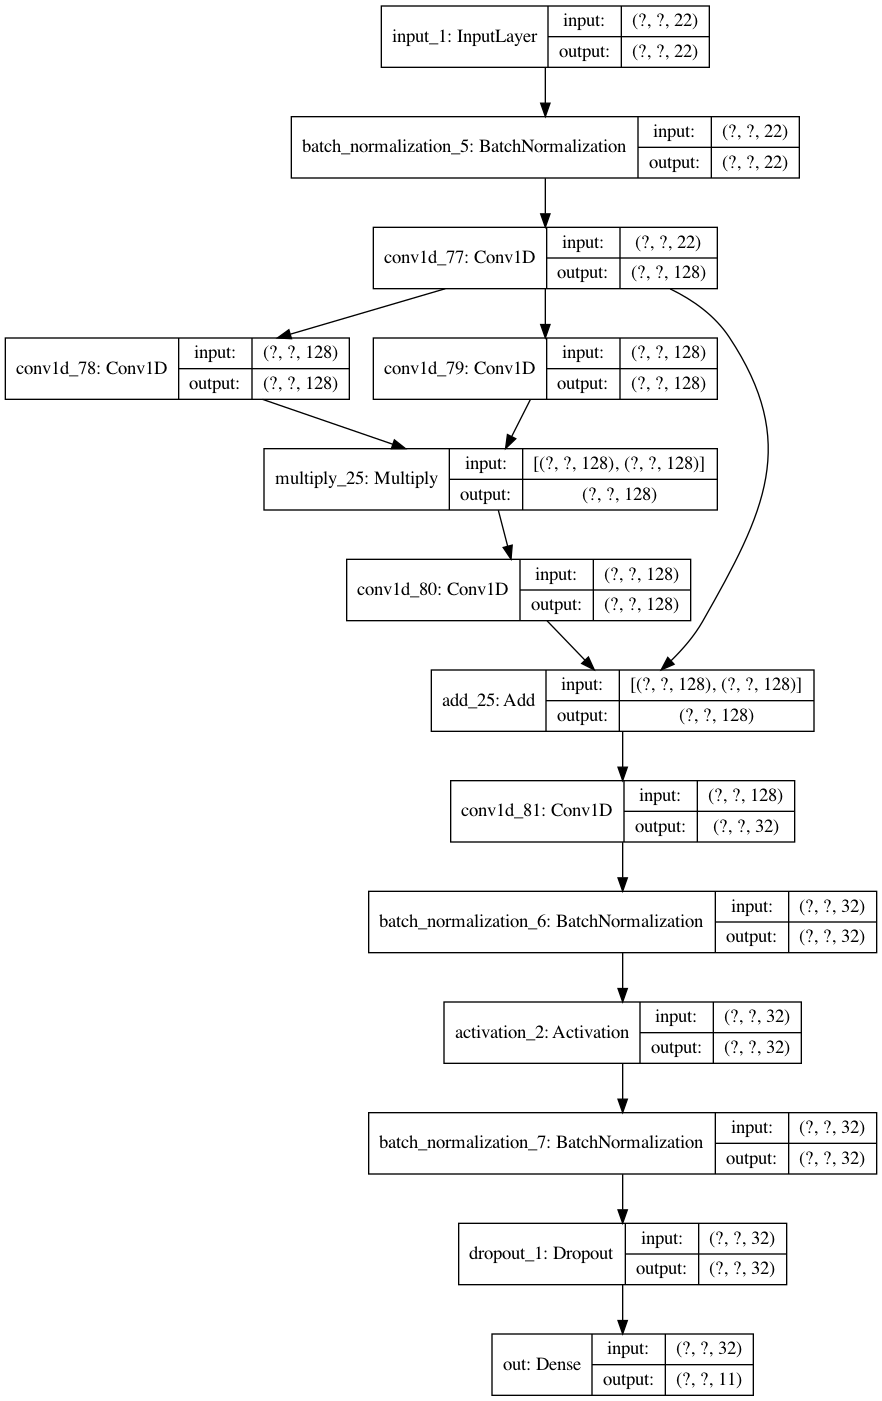

In [9]:
shape_ = (None, train.shape[1])
model = Classifier(shape_)
model.summary()

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, 22)     0                                            
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, None, 22)     88          input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_111 (Conv1D)             (None, None, 16)     368         batch_normalization_9[0][0]      
__________________________________________________________________________________________________
conv1d_112 (Conv1D)             (None, None, 128)    6272        conv1d_111[0][0]                 
__________________________________________________________________________________________________
conv1d_113

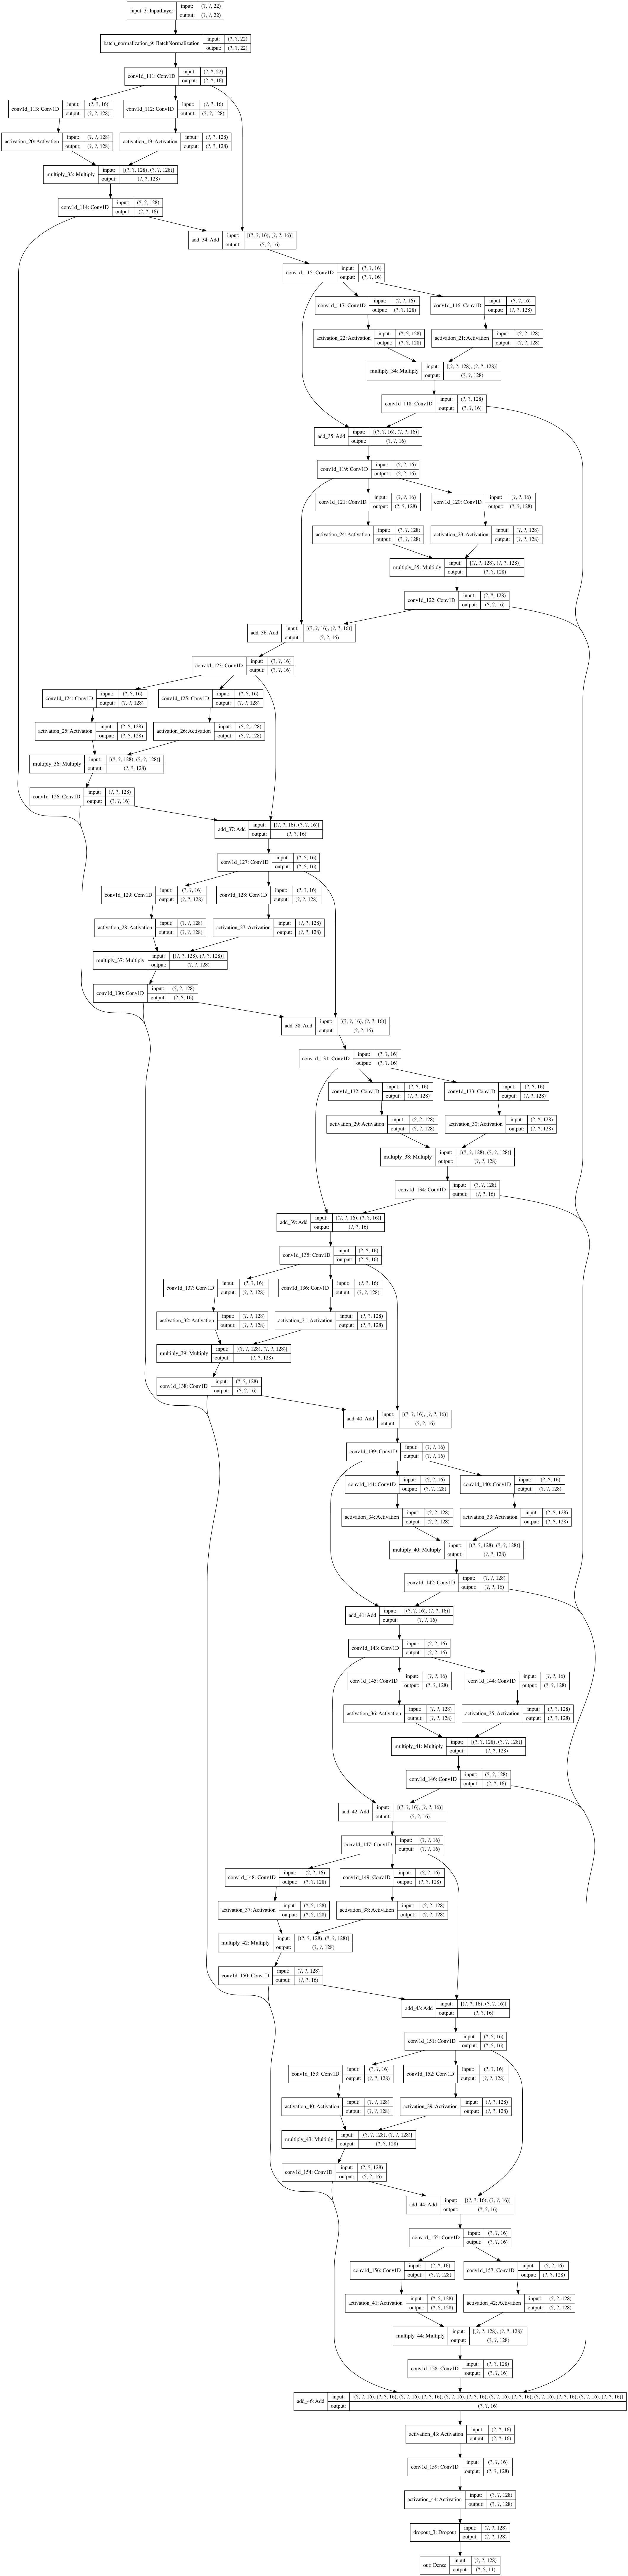

In [13]:
shape_ = (None, train.shape[1])
model_ = wavenet(shape_)
model_.summary()

plot_model(model_,
           to_file='model_plot_wavenet.png',
           show_shapes=True,
           show_layer_names=True)

In [34]:
# this function run our entire program
def run_everything():

    print('Reading Data Started...')
    train, test, sample_submission = read_data()
    train, test = normalize(train, test)
    print('Reading and Normalizing Data Completed')

    print('Creating Features')
    print('Feature Engineering Started...')
    train = run_feat_engineering(train, batch_size=GROUP_BATCH_SIZE)
    test = run_feat_engineering(test, batch_size=GROUP_BATCH_SIZE)
    train, test, features = feature_selection(train, test)
    print('Feature Engineering Completed...')

    print(
        f'Training Wavenet model with {SPLITS} folds of GroupKFold Started...')
    run_cv_model_by_batch(train, test, SPLITS, 'group', features,
                          sample_submission, EPOCHS, NNBATCHSIZE)
    print('Training completed...')


run_everything()

Reading Data Started...
Reading and Normalizing Data Completed
Creating Features
Feature Engineering Started...
Feature Engineering Completed...
Training Wavenet model with 4 folds of GroupKFold Started...


INFO:plaidml:Opening device "metal_amd_radeon_pro_560x.0"


Our training dataset shape is (1000, 4000, 19)
Our validation dataset shape is (250, 4000, 19)
Train on 1000 samples, validate on 250 samples
Epoch 1/110
 - 54s - loss: 0.8790 - acc: 0.6983 - val_loss: 0.5835 - val_acc: 0.8477
Epoch 2/110
 - 50s - loss: 0.1697 - acc: 0.9576 - val_loss: 0.3407 - val_acc: 0.9183
Epoch 3/110
 - 50s - loss: 0.1307 - acc: 0.9658 - val_loss: 0.2449 - val_acc: 0.9358
Epoch 4/110
 - 49s - loss: 0.1226 - acc: 0.9666 - val_loss: 0.1918 - val_acc: 0.9486
Epoch 5/110
 - 49s - loss: 0.1171 - acc: 0.9669 - val_loss: 0.1258 - val_acc: 0.9595
Epoch 6/110
 - 50s - loss: 0.1126 - acc: 0.9671 - val_loss: 0.1125 - val_acc: 0.9633
Epoch 7/110
 - 50s - loss: 0.1110 - acc: 0.9670 - val_loss: 0.1069 - val_acc: 0.9661
Epoch 8/110
 - 50s - loss: 0.1086 - acc: 0.9672 - val_loss: 0.1058 - val_acc: 0.9662
Epoch 9/110
 - 50s - loss: 0.1063 - acc: 0.9672 - val_loss: 0.1030 - val_acc: 0.9661
Epoch 10/110
 - 50s - loss: 0.1061 - acc: 0.9672 - val_loss: 0.1057 - val_acc: 0.9657
Epoch 1

Our training dataset shape is (1000, 4000, 19)
Our validation dataset shape is (250, 4000, 19)
Train on 1000 samples, validate on 250 samples
Epoch 1/110
 - 53s - loss: 0.9530 - acc: 0.6844 - val_loss: 0.4477 - val_acc: 0.8710
Epoch 2/110
 - 49s - loss: 0.1973 - acc: 0.9469 - val_loss: 0.2532 - val_acc: 0.9364
Epoch 3/110
 - 50s - loss: 0.1459 - acc: 0.9637 - val_loss: 0.1504 - val_acc: 0.9625
Epoch 4/110
 - 49s - loss: 0.1253 - acc: 0.9661 - val_loss: 0.1290 - val_acc: 0.9650
Epoch 5/110
 - 49s - loss: 0.1218 - acc: 0.9661 - val_loss: 0.1181 - val_acc: 0.9654
Epoch 6/110
 - 50s - loss: 0.1146 - acc: 0.9667 - val_loss: 0.1082 - val_acc: 0.9669
Epoch 7/110
 - 50s - loss: 0.1124 - acc: 0.9666 - val_loss: 0.1030 - val_acc: 0.9672
Epoch 8/110
 - 49s - loss: 0.1104 - acc: 0.9665 - val_loss: 0.1038 - val_acc: 0.9669
Epoch 9/110
 - 50s - loss: 0.1071 - acc: 0.9668 - val_loss: 0.1000 - val_acc: 0.9673
Epoch 10/110
 - 49s - loss: 0.1042 - acc: 0.9669 - val_loss: 0.0991 - val_acc: 0.9673
Epoch 1